In [1]:
!pip install -q torch torchvision matplotlib tqdm pytorch-fid --quiet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import os

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  # scale to [-1, 1]
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Use all CPU cores and larger batch size
dataloader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    num_workers=32,
    pin_memory=True
)

In [15]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.ReLU()
        )

        self.res_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        t = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t
        h = self.block2(h)
        return h + self.res_conv(x)

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(32),
            nn.Linear(32, 128),
            nn.ReLU()
        )

        self.conv1 = ResidualBlock(3, 64, 128)
        self.conv2 = ResidualBlock(64, 128, 128)
        self.conv3 = ResidualBlock(128, 128, 128)
        self.deconv1 = ResidualBlock(128, 128, 128)
        self.deconv2 = ResidualBlock(128, 64, 128)
        self.output = nn.Conv2d(64, 3, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        x1 = self.conv1(x, t_emb)
        x2 = self.conv2(x1, t_emb)
        x3 = self.conv3(x2, t_emb)
        x = self.deconv1(x3, t_emb)
        x = self.deconv2(x + x2, t_emb)
        return self.output(x + x1)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
model = SimpleUnet()

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

Using 2 GPUs


In [18]:
# Define diffusion hyperparameters
T = 300
betas = torch.linspace(1e-4, 0.02, T, device=device)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0)  # Already on GPU

# Noise images efficiently using vectorized operations
def noise_images(x, t):
    batch_size = x.shape[0]
    sqrt_alpha_hat_t = torch.sqrt(alpha_hat[t]).reshape(batch_size, 1, 1, 1)
    sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat[t]).reshape(batch_size, 1, 1, 1)
    ε = torch.randn_like(x)
    return sqrt_alpha_hat_t * x + sqrt_one_minus_alpha_hat_t * ε, ε

In [19]:
def get_loss(model, x0, t):
    x0 = x0.to(device, non_blocking=True)
    t = t.to(device)
    
    x_noisy, noise = noise_images(x0, t)
    noise_pred = model(x_noisy, t)
    return F.mse_loss(noise_pred, noise)

In [ ]:
from torchvision.utils import save_image
import os
import time
import torch

# Ensure all required variables are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleUnet()
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Image saving folder
os.makedirs("ddpm_superfinal_generated_samples", exist_ok=True)

# Time limit setup (4 hours)
start_time = time.time()
time_limit = 4 * 60 * 60  # 4 hours in seconds

# Training loop
losses_epochwise = []

print("Starting training...")
for epoch in range(5000):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    losses = []

    for step, (x, _) in enumerate(pbar):
        x = x.to(device, non_blocking=True)
        t = torch.randint(0, T, (x.shape[0],), device=device).long()
        loss = get_loss(model, x, t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbar.set_description(f"Epoch {epoch+1} | Loss: {np.mean(losses):.4f}")

    losses_epochwise.append(np.mean(losses))

    # Save generated samples every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            x = torch.randn(16, 3, 32, 32, device=device)
            for i in reversed(range(T)):
                t = torch.full((x.size(0),), i, device=device, dtype=torch.long)
                beta_t = betas[i]
                alpha_t = alphas[i]
                alpha_hat_t = alpha_hat[i]

                predicted_noise = model(x, t)
                x = (1 / torch.sqrt(alpha_t)) * (
                    x - ((1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)) * predicted_noise
                )
                if i > 0:
                    x += torch.sqrt(beta_t) * torch.randn_like(x)

            x = (x.clamp(-1, 1) + 1) / 2
            save_image(x, f"ddpm_superfinal_generated_samples/epoch_{epoch+1}.png", nrow=4)

    # Check time limit
    elapsed = time.time() - start_time
    if elapsed >= time_limit:
        print("4-hour limit reached. Saving model and exiting...")
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch + 1,
            "losses": losses_epochwise
        }, "ddpm_superfinal_model_final.pt")
        print("Model saved to ddpm_superfinal_model_final.pt")
        break

# Save model if time limit not hit
if elapsed < time_limit:
    print("Training completed within time. Saving final model...")
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": 5000,
        "losses": losses_epochwise
    }, "ddpm_superfinal_model_final.pt")
    print("Model saved to ddpm_superfinal_model_final.pt")

Using 2 GPUs
Starting training...


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 79:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 80:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 81:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 82:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 83:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 84:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 85:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 86:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 87:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 88:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 89:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 90:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 91:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 92:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 93:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 94:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 95:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 96:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 97:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 98:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 99:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 101:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 102:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 103:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 104:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 105:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 106:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 107:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 108:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 109:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 110:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 111:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 112:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 113:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 114:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 115:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 116:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 117:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 118:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 119:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 120:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 121:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 122:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 123:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 124:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 125:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 126:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 127:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 128:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 129:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 130:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 131:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 132:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 133:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 134:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 135:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 136:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 137:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 138:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 139:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 140:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 141:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 142:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 143:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 144:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 145:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 146:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 147:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 148:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 149:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 150:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 151:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 152:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 153:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 154:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 155:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 156:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 157:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 158:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 159:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 160:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 161:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 162:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 163:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 164:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 165:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 166:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 167:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 168:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 169:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 170:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 171:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 172:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 173:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 174:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 175:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 176:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 177:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 178:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 179:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 180:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 181:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 182:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 183:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 184:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 185:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 186:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 187:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 188:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 189:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 190:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 191:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 192:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 193:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 194:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 195:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 196:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 197:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 198:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 199:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 200:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 201:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 202:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 203:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 204:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 205:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 206:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 207:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 208:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 209:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 210:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 211:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 212:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 213:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 214:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 215:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 216:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 217:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 218:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 219:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 220:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 221:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 222:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 223:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 224:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 225:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 226:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 227:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 228:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 229:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 230:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 231:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 232:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 233:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 234:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 235:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 236:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 237:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 238:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 239:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 240:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 241:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 242:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 243:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 244:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 245:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 246:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 247:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 248:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 249:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 250:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 251:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 252:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 253:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 254:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 255:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 256:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 257:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 258:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 259:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 260:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 261:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 262:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 263:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 264:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 265:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 266:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 267:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 268:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 269:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 270:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 271:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 272:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 273:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 274:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 275:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 276:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 277:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 278:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 279:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 280:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 281:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 282:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 283:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 284:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 285:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 286:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 287:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 288:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 289:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 290:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 291:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 292:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 293:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 294:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 295:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 296:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 297:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 298:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 299:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 300:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 301:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 302:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 303:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 304:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 305:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 306:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 307:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 308:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 309:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 310:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 311:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 312:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 313:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 314:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 315:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 316:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 317:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 318:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 319:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 320:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 321:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 322:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 323:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 324:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 325:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 326:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 327:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 328:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 329:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 330:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 331:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 332:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 333:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 334:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 335:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 336:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 337:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 338:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 339:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 340:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 341:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 342:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 343:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 344:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 345:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 346:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 347:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 348:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 349:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 350:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 351:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 352:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 353:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 354:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 355:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 356:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 357:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 358:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 359:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 360:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 361:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 362:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 363:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 364:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 365:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 366:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 367:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 368:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 369:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 370:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 371:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 372:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 373:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 374:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 375:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 376:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 377:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 378:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 379:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 380:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 381:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 382:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 383:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 384:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 385:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 386:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 387:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 388:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 389:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 390:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 391:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 392:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 393:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 394:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 395:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 396:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 397:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 398:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 399:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 400:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 401:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 402:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 403:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 404:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 405:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 406:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 407:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 408:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 409:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 410:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 411:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 412:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 413:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 414:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 415:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 416:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 417:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 418:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 419:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 420:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 421:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 422:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 423:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 424:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 425:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 426:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 427:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 428:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 429:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 430:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 431:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 432:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 433:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 434:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 435:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 436:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 437:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 438:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 439:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 440:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 441:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 442:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 443:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 444:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 445:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 446:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 447:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 448:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 449:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 450:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 451:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 452:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 453:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 454:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 455:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 456:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 457:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 458:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 459:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 460:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 461:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 462:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 463:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 464:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 465:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 466:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 467:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 468:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 469:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 470:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 471:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 472:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 473:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 474:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 475:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 476:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 477:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 478:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 479:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 480:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 481:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 482:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 483:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 484:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 485:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 486:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 487:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 488:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 489:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 490:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 491:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 492:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 493:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 494:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 495:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 496:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 497:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 498:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 499:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 500:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 501:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 502:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 503:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 504:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 505:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 506:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 507:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 508:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 509:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 510:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 511:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 512:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 513:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 514:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 515:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 516:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 517:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 518:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 519:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 520:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 521:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 522:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 523:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 524:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 525:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 526:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 527:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 528:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 529:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 530:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 531:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 532:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 533:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 534:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 535:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 536:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 537:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 538:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 539:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 540:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 541:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 542:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 543:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 544:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 545:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 546:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 547:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 548:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 549:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 550:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 551:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 552:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 553:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 554:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 555:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 556:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 557:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 558:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 559:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 560:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 561:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 562:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 563:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 564:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 565:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 566:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 567:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 568:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 569:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 570:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 571:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 572:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 573:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 574:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 575:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 576:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 577:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 578:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 579:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 580:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 581:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 582:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 583:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 584:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 585:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 586:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 587:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 588:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 589:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 590:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 591:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 592:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 593:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 594:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 595:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 596:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 597:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 598:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 599:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 600:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 601:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 602:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 603:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 604:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 605:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 606:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 607:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 608:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 609:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 610:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 611:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 612:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 613:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 614:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 615:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 616:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 617:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 618:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 619:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 620:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 621:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 622:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 623:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 624:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 625:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 626:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 627:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 628:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 629:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 630:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 631:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 632:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 633:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 634:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 635:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 636:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 637:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 638:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 639:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 640:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 641:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 642:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 643:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 644:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 645:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 646:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 647:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 648:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 649:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 650:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 651:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 652:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 653:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 654:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 655:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 656:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 657:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 658:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 659:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 660:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 661:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 662:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 663:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 664:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 665:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 666:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 667:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 668:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 669:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 670:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 671:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 672:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 673:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 674:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 675:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 676:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 677:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 678:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 679:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 680:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 681:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 682:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 683:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 684:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 685:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 686:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 687:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 688:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 689:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 690:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 691:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 692:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 693:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 694:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 695:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 696:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 697:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 698:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 699:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 700:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 701:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 702:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 703:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 704:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 705:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 706:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 707:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 708:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 709:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 710:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 711:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 712:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 713:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 714:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 715:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 716:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 717:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 718:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 719:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 720:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 721:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 722:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 723:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 724:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 725:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 726:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 727:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 728:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 729:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 730:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 731:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 732:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 733:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 734:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 735:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 736:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 737:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 738:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 739:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 740:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 741:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 742:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 743:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 744:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 745:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 746:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 747:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 748:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 749:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 750:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 751:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 752:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 753:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 754:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 755:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 756:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 757:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 758:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 759:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 760:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 761:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 762:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 763:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 764:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 765:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 766:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 767:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 768:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 769:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 770:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 771:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 772:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 773:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 774:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 775:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 776:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 777:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 778:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 779:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 780:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 781:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 782:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 783:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 784:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 785:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 786:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 787:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 788:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 789:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 790:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 791:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 792:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 793:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 794:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 795:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 796:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 797:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 798:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 799:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 800:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 801:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 802:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 803:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 804:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 805:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 806:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 807:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 808:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 809:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 810:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 811:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 812:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 813:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 814:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 815:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 816:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 817:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 818:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 819:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 820:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 821:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 822:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 823:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 824:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 825:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 826:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 827:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 828:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 829:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 830:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 831:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 832:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 833:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 834:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 835:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 836:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 837:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 838:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 839:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 840:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 841:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 842:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 843:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 844:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 845:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 846:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 847:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 848:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 849:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 850:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 851:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 852:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 853:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 854:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 855:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 856:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 857:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 858:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 859:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 860:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 861:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 862:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 863:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 864:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 865:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 866:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 867:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 868:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 869:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 870:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 871:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 872:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 873:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 874:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 875:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 876:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 877:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 878:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 879:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 880:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 881:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 882:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 883:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 884:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 885:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 886:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 887:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 888:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 889:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 890:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 891:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 892:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 893:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 894:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 895:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 896:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 897:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 898:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 899:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 900:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 901:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 902:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 903:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 904:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 905:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 906:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 907:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 908:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 909:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 910:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 911:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 912:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 913:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 914:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 915:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 916:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 917:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 918:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 919:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 920:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 921:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 922:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 923:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 924:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 925:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 926:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 927:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 928:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 929:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 930:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 931:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 932:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 933:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 934:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 935:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 936:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 937:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 938:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 939:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 940:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 941:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 942:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 943:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 944:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 945:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 946:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 947:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 948:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 949:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 950:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 951:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 952:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 953:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 954:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 955:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 956:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 957:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 958:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 959:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 960:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 961:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 962:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 963:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 964:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 965:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 966:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 967:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 968:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 969:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 970:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 971:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 972:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 973:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 974:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 975:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 976:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 977:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 978:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 979:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 980:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 981:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 982:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 983:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 984:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 985:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 986:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 987:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 988:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 989:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 990:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 991:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 992:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 993:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 994:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 995:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 996:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 997:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 998:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 999:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1000:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1001:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1002:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1003:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1004:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1005:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1006:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1007:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1008:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1009:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1010:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1011:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1012:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1013:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1014:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1015:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1016:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1017:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1018:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1019:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1020:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1021:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1022:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1023:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1024:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1025:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1026:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1027:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1028:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1029:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1030:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1031:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1032:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1033:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1034:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1035:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1036:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1037:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1038:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1039:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1040:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1041:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1042:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1043:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1044:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1045:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1046:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1047:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1048:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1049:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1050:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1051:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1052:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1053:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1054:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1055:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1056:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1057:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1058:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1059:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1060:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1061:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1062:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1063:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1064:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1065:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1066:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1067:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1068:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1069:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1070:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1071:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1072:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1073:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1074:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1075:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1076:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1077:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1078:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1079:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1080:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1081:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1082:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1083:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1084:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1085:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1086:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1087:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1088:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1089:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1090:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1091:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1092:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1093:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1094:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1095:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1096:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1097:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1098:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1099:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1101:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1102:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1103:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1104:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1105:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1106:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1107:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1108:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1109:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1110:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1111:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1112:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1113:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1114:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1115:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1116:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1117:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1118:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1119:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1120:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1121:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1122:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1123:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1124:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1125:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1126:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1127:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1128:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1129:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1130:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1131:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1132:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1133:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1134:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1135:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1136:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1137:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1138:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1139:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1140:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1141:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1142:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1143:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1144:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1145:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1146:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1147:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1148:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1149:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1150:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1151:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1152:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1153:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1154:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1155:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1156:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1157:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1158:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1159:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1160:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1161:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1162:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1163:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1164:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1165:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1166:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1167:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1168:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1169:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1170:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1171:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1172:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1173:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1174:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1175:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1176:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1177:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1178:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1179:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1180:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1181:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1182:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1183:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1184:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1185:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1186:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1187:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1188:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1189:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1190:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1191:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1192:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1193:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1194:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1195:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1196:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1197:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1198:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1199:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1200:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1201:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1202:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1203:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1204:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1205:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1206:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1207:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1208:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1209:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1210:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1211:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1212:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1213:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1214:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1215:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1216:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1217:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1218:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1219:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1220:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1221:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1222:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1223:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1224:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1225:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1226:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1227:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1228:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1229:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1230:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1231:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1232:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1233:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1234:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1235:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1236:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1237:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1238:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1239:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1240:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1241:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1242:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1243:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1244:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1245:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1246:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1247:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1248:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1249:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1250:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1251:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1252:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1253:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1254:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1255:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1256:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1257:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1258:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1259:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1260:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1261:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1262:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1263:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1264:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1265:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1266:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1267:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1268:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1269:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1270:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1271:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1272:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1273:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1274:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1275:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1276:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1277:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1278:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1279:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1280:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1281:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1282:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1283:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1284:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1285:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1286:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1287:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1288:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1289:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1290:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1291:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1292:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1293:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1294:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1295:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1296:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1297:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1298:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1299:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1300:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1301:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1302:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1303:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1304:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1305:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1306:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1307:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1308:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1309:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1310:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1311:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1312:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1313:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1314:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1315:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1316:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1317:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1318:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1319:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1320:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1321:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1322:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1323:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1324:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1325:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1326:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1327:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1328:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1329:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1330:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1331:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1332:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1333:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1334:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1335:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1336:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1337:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1338:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1339:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1340:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1341:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1342:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1343:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1344:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1345:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1346:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1347:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1348:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1349:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1350:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1351:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1352:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1353:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1354:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1355:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1356:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1357:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1358:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1359:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1360:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1361:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1362:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1363:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1364:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1365:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1366:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1367:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1368:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1369:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1370:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1371:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1372:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1373:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1374:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1375:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1376:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1377:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1378:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1379:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1380:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1381:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1382:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1383:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1384:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1385:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1386:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1387:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1388:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1389:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1390:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1391:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1392:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1393:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1394:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1395:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1396:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1397:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1398:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1399:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1400:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1401:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1402:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1403:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1404:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1405:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1406:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1407:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1408:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1409:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1410:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1411:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1412:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1413:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1414:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1415:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1416:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1417:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1418:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1419:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1420:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1421:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1422:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1423:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1424:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1425:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1426:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1427:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1428:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1429:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1430:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1431:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1432:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1433:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1434:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1435:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1436:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1437:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1438:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1439:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1440:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1441:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1442:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1443:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1444:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1445:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1446:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1447:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1448:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1449:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1450:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1451:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1452:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1453:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1454:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1455:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1456:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1457:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1458:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1459:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1460:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1461:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1462:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1463:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1464:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1465:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1466:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1467:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1468:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1469:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1470:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1471:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1472:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1473:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1474:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1475:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1476:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1477:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1478:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1479:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1480:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1481:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1482:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1483:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1484:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1485:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1486:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1487:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1488:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1489:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1490:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1491:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1492:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1493:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1494:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1495:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1496:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1497:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1498:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1499:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1500:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1501:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1502:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1503:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1504:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1505:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1506:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1507:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1508:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1509:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1510:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1511:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1512:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1513:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1514:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1515:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1516:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1517:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1518:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1519:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1520:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1521:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1522:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1523:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1524:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1525:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1526:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1527:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1528:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1529:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1530:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1531:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1532:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1533:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1534:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1535:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1536:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1537:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1538:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1539:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1540:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1541:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1542:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1543:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1544:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1545:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1546:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1547:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1548:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1549:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1550:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1551:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1552:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1553:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1554:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1555:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1556:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1557:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1558:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1559:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1560:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1561:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1562:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1563:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1564:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1565:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1566:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1567:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1568:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1569:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1570:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1571:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1572:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1573:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1574:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1575:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1576:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1577:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1578:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1579:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1580:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1581:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1582:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1583:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1584:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1585:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1586:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1587:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1588:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1589:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1590:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1591:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1592:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1593:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1594:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1595:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1596:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1597:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1598:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1599:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1600:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1601:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1602:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1603:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1604:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1605:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1606:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1607:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1608:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1609:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1610:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1611:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1612:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1613:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1614:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1615:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1616:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1617:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1618:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1619:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1620:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1621:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1622:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1623:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1624:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1625:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1626:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1627:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1628:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1629:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1630:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1631:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1632:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1633:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1634:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1635:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1636:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1637:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1638:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1639:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1640:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1641:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1642:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1643:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1644:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1645:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1646:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1647:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1648:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1649:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1650:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1651:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1652:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1653:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1654:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1655:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1656:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1657:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1658:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1659:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1660:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1661:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1662:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1663:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1664:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1665:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1666:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1667:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1668:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1669:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1670:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1671:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1672:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1673:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1674:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1675:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1676:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1677:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1678:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1679:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1680:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1681:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1682:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1683:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1684:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1685:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1686:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1687:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1688:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1689:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1690:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1691:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1692:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1693:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1694:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1695:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1696:   0%|          | 0/196 [00:00<?, ?it/s]

⏰ 4-hour limit reached. Saving model and exiting...
Model saved to ddpm_superfinal_model_final.pt


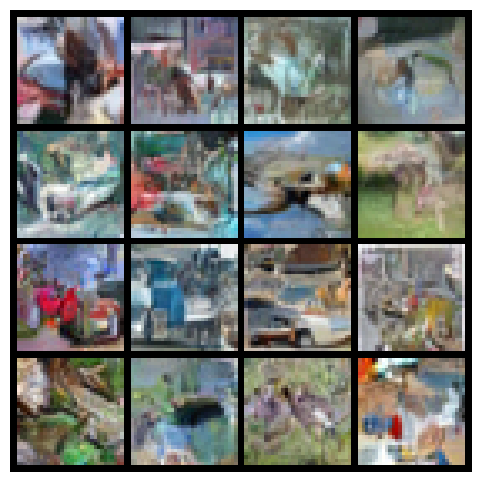

In [21]:
@torch.no_grad()
def sample_plot_image_ddim(model, n=16, img_size=32, eta=0.0):
    model.eval()
    x = torch.randn((n, 3, img_size, img_size), device=device)

    for t in reversed(range(1, T)):
        t_batch = torch.full((n,), t, device=device, dtype=torch.long)

        predicted_noise = model(x, t_batch)
        alpha_t = alpha_hat[t]
        alpha_t_prev = alpha_hat[t - 1] if t > 0 else alpha_hat[0]
        beta_t = betas[t]

        # Estimate x0
        x0_pred = (x - torch.sqrt(1 - alpha_t) * predicted_noise) / torch.sqrt(alpha_t)

        # DDIM-like update
        sigma = eta * torch.sqrt((1 - alpha_t_prev) / (1 - alpha_t) * beta_t)
        noise = torch.randn_like(x) if eta > 0 else 0

        x = torch.sqrt(alpha_t_prev) * x0_pred + torch.sqrt(1 - alpha_t_prev - sigma**2) * predicted_noise + sigma * noise

    # Final normalization
    x = (x.clamp(-1, 1) + 1) / 2
    grid = make_grid(x, nrow=4)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
sample_plot_image_ddim(model, eta=0.0)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
import torchvision.transforms as TF

gen_dir = './new_generated'
real_dir = './real'
os.makedirs(gen_dir, exist_ok=True)
os.makedirs(real_dir, exist_ok=True)

# ----------------------------
# IMAGE GENERATION (Reverse Sampling)
# ----------------------------
@torch.no_grad()
def generate_images(model, count=1000):
    model.eval()
    for i in tqdm(range(count), desc="Generating fake images"):
        x = torch.randn((1, 3, 32, 32), device=device)
        for t in reversed(range(T)):
            t_batch = torch.full((1,), t, device=device, dtype=torch.long)
            pred = model(x, t_batch)
            alpha = alphas[t]
            alpha_hat_t = alpha_hat[t]
            beta = betas[t]
            noise = torch.randn_like(x) if t > 0 else 0
            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_hat_t)) * pred) + torch.sqrt(beta) * noise
        x = (x.clamp(-1, 1) + 1) / 2
        save_image(x, os.path.join(gen_dir, f"{i}.png"))

# ----------------------------
# SAVE REAL CIFAR-10 IMAGES
# ----------------------------
def save_real_images(count=1000):
    transform = TF.Compose([
        TF.Resize(32),
        TF.ToTensor(),
        TF.Lambda(lambda t: (t * 2) - 1)  # Match your model's normalization
    ])
    real_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    
    for i in tqdm(range(count), desc="Saving real CIFAR-10 images"):
        img, _ = real_dataset[i]
        save_image((img + 1) / 2, os.path.join(real_dir, f"{i}.png"))  # Un-normalize before saving

# ----------------------------
# COMPUTE FID
# ----------------------------
def compute_fid(real_dir, gen_dir):
    fid = fid_score.calculate_fid_given_paths([real_dir, gen_dir], batch_size=50, device=device, dims=2048)
    print(f"\nFID Score: {fid:.2f}")

# ----------------------------
# FULL EXECUTION
# ----------------------------
generate_images(model)    # model must be your trained SimpleUnet or DDPM model
save_real_images()
compute_fid(real_dir, gen_dir)

Generating fake images:   0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'CIFAR10' is not defined

In [24]:
import os
from torchvision.datasets import CIFAR10
from torchvision import transforms as TF
from torchvision.utils import save_image
from tqdm import tqdm

def save_real_images_to_real_dir(count=1000, out_dir='./real'):
    os.makedirs(out_dir, exist_ok=True)

    transform = TF.Compose([
        TF.ToTensor(),
        TF.Lambda(lambda t: (t * 2) - 1)  # match DDPM training normalization
    ])

    dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)

    for i in tqdm(range(count), desc="Saving real CIFAR-10 test images"):
        img, _ = dataset[i]
        save_image((img + 1) / 2, os.path.join(out_dir, f"{i}.png"))  # scale to [0,1] for FID

# Call the function
save_real_images_to_real_dir()

Saving real CIFAR-10 test images: 100%|██████████| 1000/1000 [00:03<00:00, 308.84it/s]


In [25]:
import torch
from pytorch_fid import fid_score

# Paths to image folders
gen_dir = './new_generated'
real_dir = './real'

# Compute FID
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fid = fid_score.calculate_fid_given_paths([real_dir, gen_dir],
                                          batch_size=100,
                                          device=device,
                                          dims=2048)

print(f"\n FID Score: {fid:.2f}")

100%|██████████| 10/10 [00:00<00:00, 13.79it/s]



 FID Score: 103.92


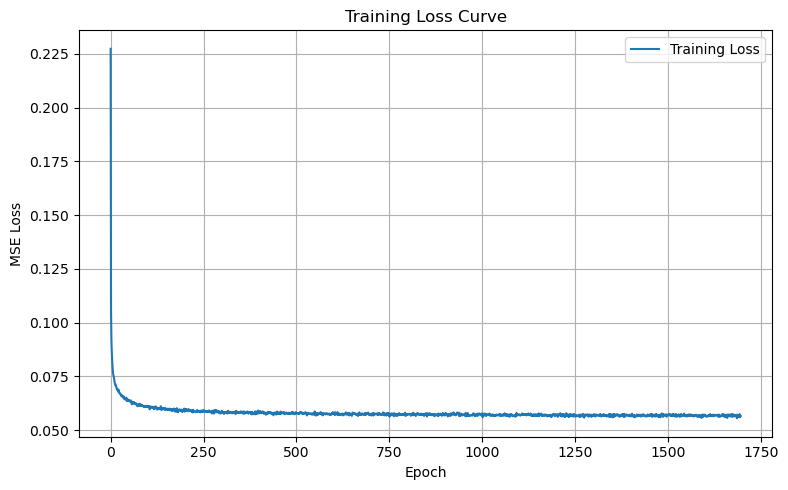

In [26]:
import matplotlib.pyplot as plt

# Plot training loss curve
plt.figure(figsize=(8, 5))
plt.plot(losses_epochwise, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

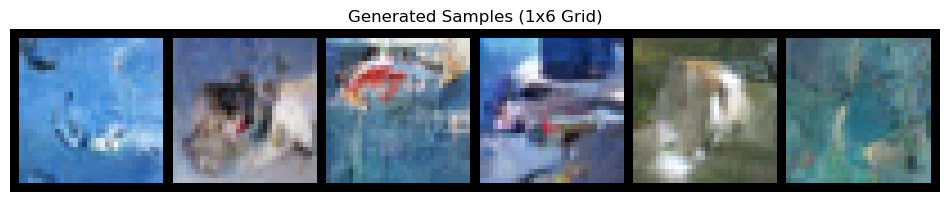

In [27]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

@torch.no_grad()
def plot_1x6_generated_samples(model):
    model.eval()
    x = torch.randn(6, 3, 32, 32).to(device)

    for t in reversed(range(T)):
        t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)
        pred = model(x, t_batch)
        alpha = alphas[t]
        alpha_hat_t = alpha_hat[t]
        beta = betas[t]
        noise = torch.randn_like(x) if t > 0 else 0
        x = (1 / torch.sqrt(alpha)) * (
            x - ((1 - alpha) / torch.sqrt(1 - alpha_hat_t)) * pred
        ) + torch.sqrt(beta) * noise

    x = (x.clamp(-1, 1) + 1) / 2  # scale to [0, 1]
    grid = make_grid(x, nrow=6)  # 1 row, 6 columns

    plt.figure(figsize=(12, 2.5))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title("Generated Samples (1x6 Grid)")
    plt.show()

# Run the function
plot_1x6_generated_samples(model)